In [1]:
import tensorflow as tf
from tensorflow import keras
import os
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Activation,Flatten,Dropout,AveragePooling2D
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import cv2,os
data_path=r'C:\Users\sreek\Cloud\data'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels))

print(label_dict)
print(categories)
print(labels)

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]


In [3]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 100x100, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

In [4]:
import numpy as np

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)


from keras import utils
new_target=utils.to_categorical(target)

#from keras.utils import utils
#new_target=np_utils.to_categorical(target)

In [5]:
np.save('data',data)
np.save('target',new_target)

In [6]:
import numpy as np

data = np.load('data.npy')
target = np.load('target.npy')

In [7]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D,Input
from keras.callbacks import ModelCheckpoint

model = Sequential()

input_shape = data.shape[1:]
model.add(Input(shape=input_shape))
#model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50,activation='relu'))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [8]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [9]:
#checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
#history=model.fit(train_data,train_target,epochs=20,callbacks=[checkpoint],validation_split=0.2)
checkpoint = ModelCheckpoint('model-{epoch:03d}.keras',monitor='val_loss',verbose=0,save_best_only=True,mode='auto') # add '.keras' extension to the filename
history=model.fit(train_data,train_target,epochs=5,callbacks=[checkpoint],validation_split=0.2)

Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.5651 - loss: 0.8559 - val_accuracy: 0.6855 - val_loss: 0.5801
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.6998 - loss: 0.5634 - val_accuracy: 0.8468 - val_loss: 0.4448
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.8210 - loss: 0.4284 - val_accuracy: 0.8548 - val_loss: 0.3954
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.8583 - loss: 0.3281 - val_accuracy: 0.8710 - val_loss: 0.3242
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9082 - loss: 0.2538 - val_accuracy: 0.8226 - val_loss: 0.4261


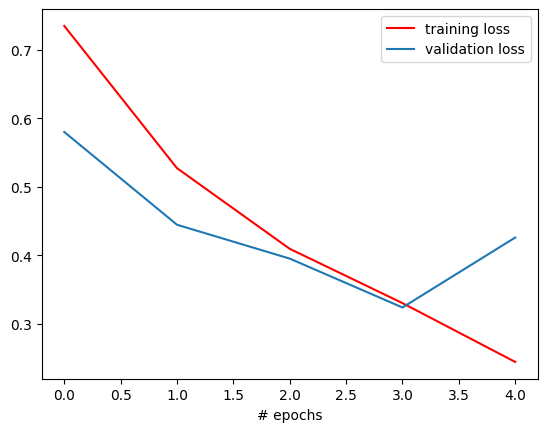

In [10]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.legend()
plt.show()

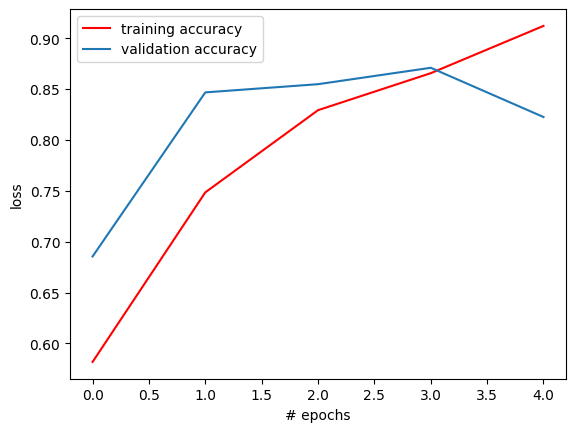

In [11]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [12]:
from keras.models import load_model
import cv2
import numpy as np

#model = load_model('model-001.keras') # Change the file extension to '.keras'
model = load_model('model-005.keras')

face_clsfr=cv2.CascadeClassifier(r'C:\Anaconda\Cloud\haarcascade_frontalface_default.xml')

source=cv2.VideoCapture(0)
#source=cv2.imread('/content/drive/My Drive/datasetts/Anusha.png')

labels_dict={0:'No MASK',1:'NO MASK'}
color_dict={0:(0,255,0),1:(0,0,255)}

In [13]:
while(True):

    ret,img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  

    for x,y,w,h in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\objdetect\src\cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'cv::CascadeClassifier::detectMultiScale'
